In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model


In [2]:

df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)

In [3]:
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)

def forcast_next_minute(_20_minute_data, garch_fit, order_arima=(1, 1, 1), order_garch=(1, 1), predicted_volatility=[]):
    """
    Forecast the next minute using ARIMA and ARCH models.
    :param _20_minute_data: DataFrame with 20 minutes of data
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: Forecasted value for the next minute
    """
    # Fit ARIMA model
    arima_model = ARIMA(_20_minute_data, order=order_arima)
    arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]
    
    arima_forecast = func_of_arima_1_1_1(
        t_1_data=_20_minute_data.iloc[-1],
        t_2_data=_20_minute_data.iloc[-2],
        ar_param=ar_param,
        ma_param=ma_param,
        prev_residual=residual_np[-1]
    )

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility
    if len(predicted_volatility) == 0:
        
        vol_garch = garch_fit.conditional_volatility
        
        forecast_garch = func_of_garch_1_1(
            omega,
            alpha,
            beta,
            vol_garch[-1],
            residual_np[-1]
        )
    else:
        forecast_garch = func_of_garch_1_1(
            omega,
            alpha,
            beta,
            predicted_volatility[-1],
            residual_np[-1]
        )
    predicted_volatility.append(forecast_garch)

    return arima_forecast, forecast_garch, predicted_volatility

In [4]:
def rolling_forecast(df, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1), garch_fit=None):
    """
    Perform rolling forecast on the DataFrame.
    :param df: DataFrame with the data
    :param window_size: Size of the rolling window
    :param order_arima: Order of the ARIMA model
    :param order_arch: Order of the ARCH model
    :return: List of forecasted values
    """
    forecasts_mid = []
    forecast_vol = []
    predicted_volatility = []

    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


    for i in range(window_size, len(df)):
        if i == len(df)//2:
            print("Halfway through the data, fitting GARCH model")
            print(predicted_volatility)
        _20_minute_data = df.iloc[i-window_size:i]
        arima_forecast, garch_forecast, predicted_volatility = forcast_next_minute(_20_minute_data,
                                                             garch_fit=garch_fit, 
                                                             order_arima=order_arima, 
                                                             order_garch=order_arch, 
                                                             predicted_volatility = predicted_volatility
                                                             )
        forecasts_mid.append(arima_forecast)
        forecast_vol.append(garch_forecast)  # Get the last forecasted varianc
    
    return forecasts_mid, forecast_vol

In [5]:
data = df["close_scaled_down"].loc["2025-01-31 15:11":"2025-03-03 23:00"]
data_to_garch = df["close_scaled_down"].loc["2024-12-31":"2025-02-01 09:00"]
data_to_garch = data_to_garch.dropna()
# fit the Arima model
arima_for_1_month = ARIMA(data_to_garch, order=(1, 1, 1))
arima_for_1_month_fit = arima_for_1_month.fit()

rsidual_for_1_month = np.array(arima_for_1_month_fit.resid)
# fit the Garch model
garch_for_1_month = arch_model(rsidual_for_1_month, vol='Garch', p=1, q=1)
garch_for_1_month_fit = garch_for_1_month.fit(disp="off")

vol_garch_for_1_month = garch_for_1_month_fit.conditional_volatility


forecasts_mid, forecast_vol = rolling_forecast(data, window_size=20, order_arima=(1, 1, 1), order_arch=(1, 1), garch_fit=garch_for_1_month_fit)


/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Halfway through the data, fitting GARCH model
[np.float64(0.8262368714124887), np.float64(0.8133333442188093), np.float64(1.0379435696205765), np.float64(1.1016637339062243), np.float64(0.8911986906009968), np.float64(0.8977017965072729), np.float64(0.8863772554707695), np.float64(0.8382065946301409), np.float64(0.8532267831170725), np.float64(0.8574601902299895), np.float64(0.8499200738493657), np.float64(0.8517857671717098), np.float64(0.9626232712821386), np.float64(0.8839158629599048), np.float64(0.8923256915517324), np.float64(0.8221301012208725), np.float64(1.5400532153823383), np.float64(1.769284516668724), np.float64(1.9395211629368492), np.float64(1.1813792890238155), np.float64(0.8940341336798519), np.float64(0.9453763467708718), np.float64(0.9758258613226394), np.float64(1.104982753518661), np.float64(0.9913383090965647), np.float64(0.8391458636371113), np.float64(0.8813727895448689), np.float64(1.4052321703776722), np.float64(0.9206844437142115), np.float64(0.88620794907013

In [6]:
len(forecasts_mid), len(forecast_vol)

(7875, 7875)

In [39]:
# find rmse for forcasts_mid and data
rmse_mid = np.sqrt(np.mean((np.array(forecasts_mid) - data.iloc[20:]) ** 2))
rmse_mid
# R-squared for forecasts_mid and data
r_squared_mid = 1 - (np.sum((data.iloc[20:].values - forecasts_mid) ** 2) / np.sum((data.iloc[20:].values - np.mean(data.iloc[20:].values)) ** 2))
r_squared_mid

np.float64(0.9994270297142175)

In [35]:
# create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'forecast_mid': forecasts_mid,
    'forecast_vol': forecast_vol
}, index=data.index[20:])
# save the forecast DataFrame to a CSV file
forecast_df.to_csv('/home/vishi/bolinger/forecast_mid_and_vol.csv')

In [36]:
len(forecast_df)

7875

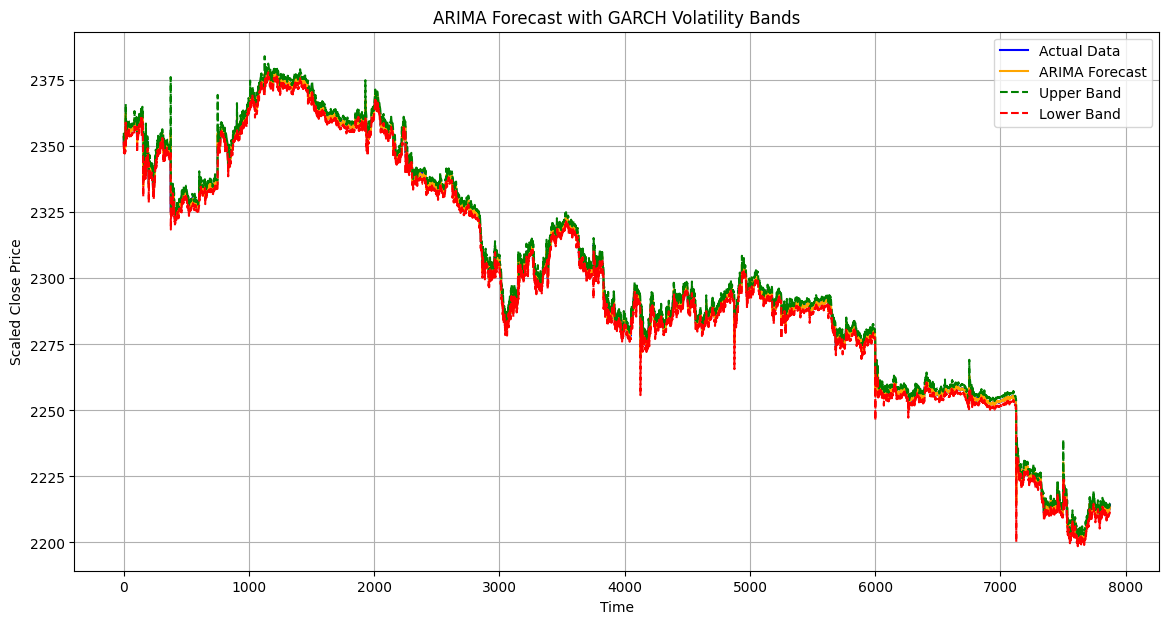

In [7]:
upper_band_arima = np.array(forecasts_mid) + 2 * np.array(forecast_vol)
lower_band_arima = np.array(forecasts_mid) - 2 * np.array(forecast_vol)
plt.figure(figsize=(14, 7))
plt.plot(np.array(df["close_scaled_down"].loc["2025-02-01 09:00":"2025-03-03 23:00"]), label='Actual Data', color='blue')
plt.plot(np.array(forecasts_mid), label='ARIMA Forecast', color='orange')
plt.plot(upper_band_arima, label='Upper Band', color='green', linestyle='--')
plt.plot(lower_band_arima, label='Lower Band', color='red', linestyle='--')

plt.legend()
plt.title('ARIMA Forecast with GARCH Volatility Bands')
plt.xlabel('Time')
# zoom between x axix 400 to 600
# plt.xlim(1000,1200)
# plt.ylim(2360,2385)
plt.ylabel('Scaled Close Price')
plt.grid()
plt.show()

In [8]:
def strategy_profit_with_stop_loss(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return profit_ts, buy_signal, sell_signal

In [9]:
len(forecasts_mid),len(upper_band_arima), len(lower_band_arima)
len(data.loc["2025-02-01 09:00":"2025-03-03 23:00"])

7875

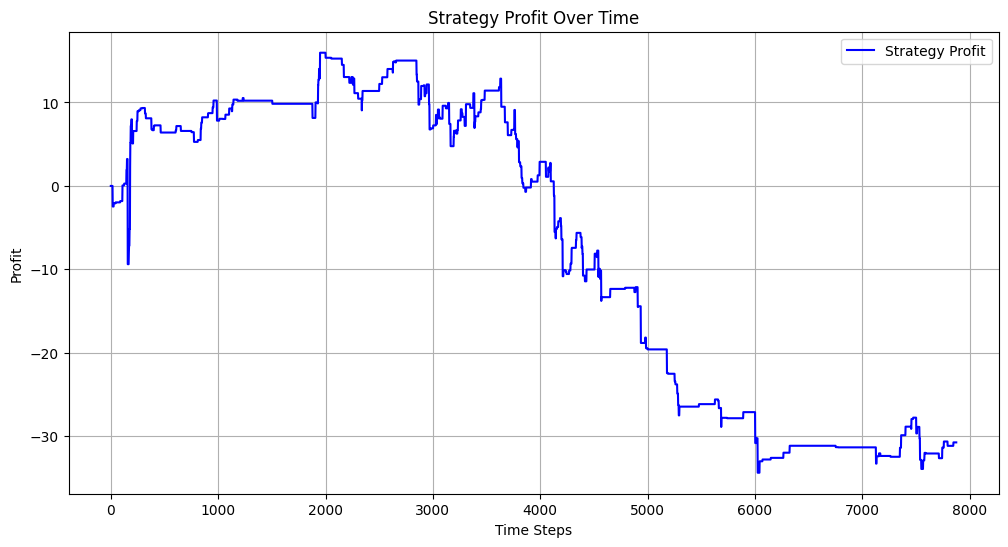

In [10]:
profit_ts, buy_signal, sell_signal = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima, upper_band_arima, stop_loss=100)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts, label='Strategy Profit', color='blue')

plt.legend()
plt.title('Strategy Profit Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()


In [21]:
# save the profit_ts in npy file

np.save('/home/vishi/bolinger/profit_ts_rolling.npy', np.array(profit_ts))

In [11]:
len(profit_ts)

7875

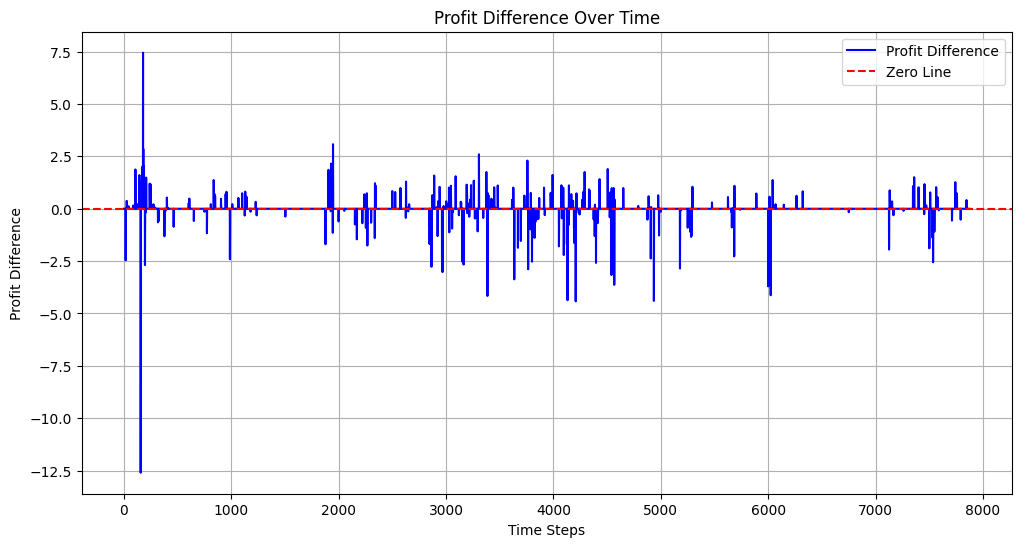

In [12]:
profit_diff = np.diff(profit_ts)
plt.figure(figsize=(12, 6))
plt.plot(profit_diff, label='Profit Difference', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.title('Profit Difference Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit Difference')
plt.grid()
plt.show()

In [13]:
len(profit_diff)

7874

In [14]:
list_of_periods = [5, 10, 15, 20]
list_of_k = [1, 1.5, 2]

def calculate_profit_for_k_and_period(k, period, closing_prices, stop_loss = 0.1):
    """
    Calculate profit for a given k and period.
    
    :param k: Multiplier for the volatility bands
    :param period: Period for the rolling window
    :param closing_prices: Closing prices of the asset
    :param stop_loss: Stop loss percentage
    :return: Profit time series, buy signals, sell signals
    """
    mid_band = closing_prices.rolling(window=period).mean()
    volatility = closing_prices.rolling(window=period).std()
    
    upper_band = mid_band + k * volatility
    lower_band = mid_band - k * volatility
    
    return strategy_profit_with_stop_loss(closing_prices, mid_band, lower_band, upper_band, stop_loss)[0]
profit_for_different_strategies = []
for period in list_of_periods:
    for k in list_of_k:
        profit_for_different_strategies.append(calculate_profit_for_k_and_period(k, period, df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'], stop_loss=100))
profit_for_different_strategies = np.array(profit_for_different_strategies)
        

/tmp/ipykernel_3099/1000589822.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if closing_prices[i] < lower_band[i]:
/tmp/ipykernel_3099/1000589822.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif closing_prices[i] > upper_band[i]:
/tmp/ipykernel_3099/1000589822.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price = closing_prices[i]
/tmp/ipykernel_3099/1000589822.py:23: FutureWarning: Series.__getitem__ tr

In [15]:
len(profit_for_different_strategies[0])

7875

In [16]:
list_of_returns = []
for i in range(profit_for_different_strategies.shape[0]):
    list_of_returns.append(np.diff(profit_for_different_strategies[i]))


In [17]:
len(list_of_returns[0])

7874

In [18]:
benchmark_returns = np.array(profit_diff)
benchmark_losses = -benchmark_returns
strategy_losses = -np.array(list_of_returns).T
spa = SPA(benchmark_losses, strategy_losses)
spa.compute()
better_model_indices = spa.better_models(pvalue=0.05, pvalue_type="lower")
print("Indices of strategies that are better than the benchmark:", better_model_indices)
# len(benchmark_losses)

Indices of strategies that are better than the benchmark: []


In [19]:
def strategy_profit_for_no_of_trades(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    no_of_trades = 0
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
                no_of_trades += 1
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
                no_of_trades += 1
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return no_of_trades

In [20]:
print(strategy_profit_for_no_of_trades(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima, upper_band_arima, stop_loss=100))

261


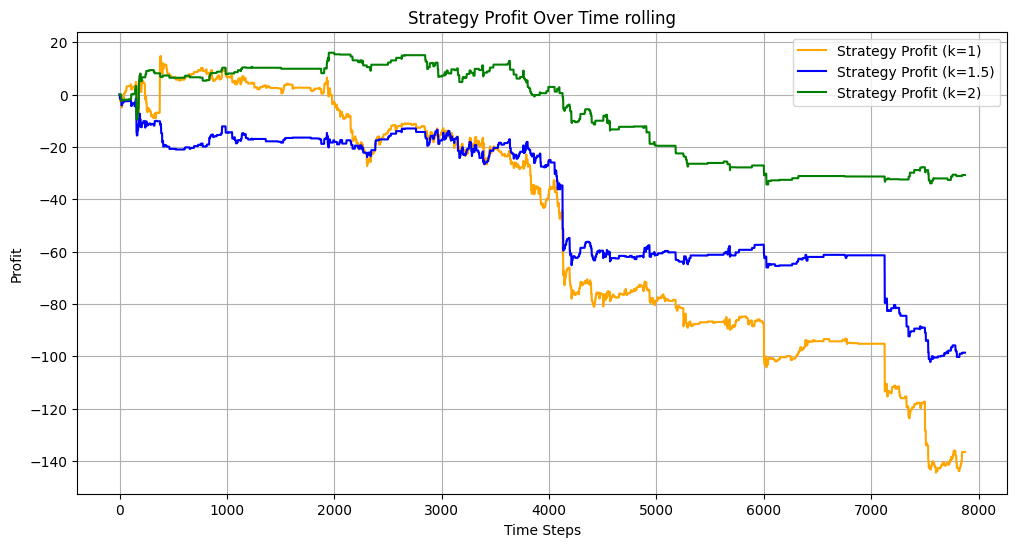

In [23]:
upper_band_arima_1_5 = np.array(forecasts_mid) + 1.5 * np.array(forecast_vol)
lower_band_arima_1_5 = np.array(forecasts_mid) - 1.5 * np.array(forecast_vol)

upper_band_arima_1 = np.array(forecasts_mid) +  np.array(forecast_vol)
lower_band_arima_1 = np.array(forecasts_mid) -  np.array(forecast_vol)

profit_ts_1_5, buy_signal_1_5, sell_signal_1_5 = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima_1_5, upper_band_arima_1_5, stop_loss=100) 
profit_ts_1, buy_signal_1, sell_signal_1 = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima_1, upper_band_arima_1, stop_loss=100)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts_1, label='Strategy Profit (k=1)', color='orange')
plt.plot(profit_ts_1_5, label='Strategy Profit (k=1.5)', color='blue')
plt.plot(profit_ts, label='Strategy Profit (k=2)', color='green')

plt.legend()
plt.title('Strategy Profit Over Time rolling')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()

In [24]:
def strategy_profit_for_no_of_trades_ts(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    no_of_trades = 0
    trades_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
                no_of_trades += 1
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
                no_of_trades += 1
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
        trades_ts.append(no_of_trades)
    return trades_ts


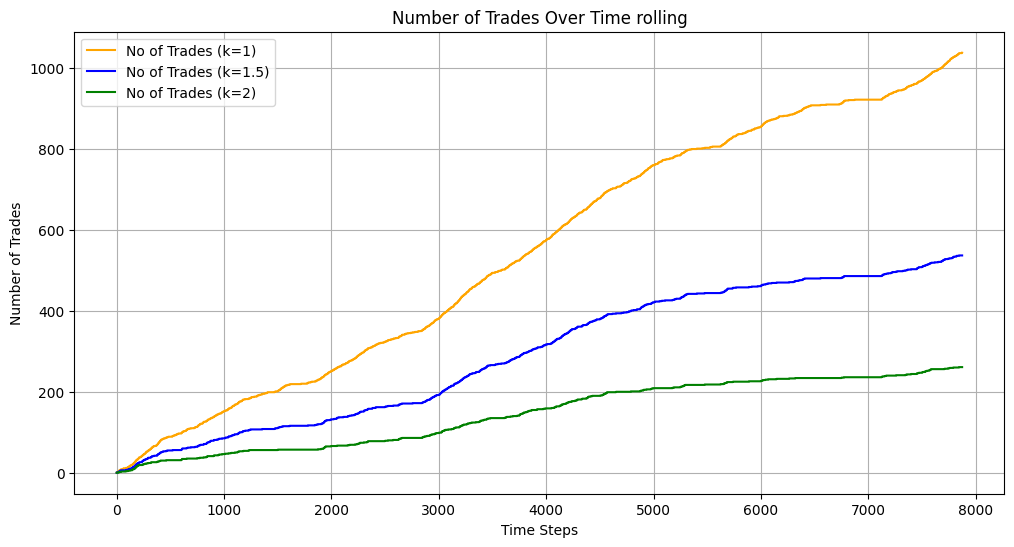

In [25]:
strategy_profit_for_no_of_trades_ts_1 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima_1, upper_band_arima_1, stop_loss=100)
strategy_profit_for_no_of_trades_ts_1_5 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima_1_5, upper_band_arima_1_5, stop_loss=100)
strategy_profit_for_no_of_trades_ts_2 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , forecasts_mid, lower_band_arima, upper_band_arima, stop_loss=100)
plt.figure(figsize=(12, 6))
plt.plot(strategy_profit_for_no_of_trades_ts_1, label='No of Trades (k=1)', color='orange')
plt.plot(strategy_profit_for_no_of_trades_ts_1_5, label='No of Trades (k=1.5)', color='blue')
plt.plot(strategy_profit_for_no_of_trades_ts_2, label='No of Trades (k=2)', color='green')
plt.legend()
plt.title('Number of Trades Over Time rolling')
plt.xlabel('Time Steps')
plt.ylabel('Number of Trades')
plt.grid()
plt.show()


In [29]:
print(" k=1:", strategy_profit_for_no_of_trades_ts_1[-1])
print(" k=1.5:", strategy_profit_for_no_of_trades_ts_1_5[-1])
print(" k=2:", strategy_profit_for_no_of_trades_ts_2[-1])

 k=1: 1038
 k=1.5: 537
 k=2: 261


In [32]:
# use profit diff and find the {
    #     'Sharpe Ratio': sharpe_ratio,
    #     'Sortino Ratio': sortino_ratio,
    #     'Max Drawdown': max_drawdown,
    #     'CAGR': cagr,
    #     'Calmar Ratio': calmar_ratio,
    #     'Volatility': volatility
    # }
def calculate_performance_metrics(profit_ts):
    """    Calculate performance metrics for the given returns.
    :param returns: Array of returns    
    :return: Dictionary of performance metrics
    """
    returns = np.array(np.diff(profit_ts))
    sharpe_ratio = np.mean(returns) / np.std(returns)
    sortino_ratio = np.mean(returns) / np.std(returns[returns < 0])
    max_drawdown = np.max(np.maximum.accumulate(returns) - returns)
    cagr = (1 + returns[-1]) ** (252 / len(returns)) - 1
    calmar_ratio = cagr / max_drawdown if max_drawdown != 0 else np.nan
    volatility = np.std(returns)

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'CAGR': cagr,
        'Calmar Ratio': calmar_ratio,
        'Volatility': volatility
    }

In [33]:
metric_1_rolling = calculate_performance_metrics(profit_ts_1)
metric_1_5_rolling = calculate_performance_metrics(profit_ts_1_5)
metric_2_rolling = calculate_performance_metrics(profit_ts)

In [34]:
print("metric for k=1:", metric_1_rolling)
print("metric for k=1.5:", metric_1_5_rolling)
print("metric for k=2:", metric_2_rolling)

metric for k=1: {'Sharpe Ratio': np.float64(-0.026631491749326202), 'Sortino Ratio': np.float64(-0.009037239634723504), 'Max Drawdown': np.float64(38.914999999999964), 'CAGR': np.float64(0.0), 'Calmar Ratio': np.float64(0.0), 'Volatility': np.float64(0.6512511522385307)}
metric for k=1.5: {'Sharpe Ratio': np.float64(-0.026458417754019466), 'Sortino Ratio': np.float64(-0.006015083927788266), 'Max Drawdown': np.float64(21.269999999999982), 'CAGR': np.float64(0.0), 'Calmar Ratio': np.float64(0.0), 'Volatility': np.float64(0.47337543635343265)}
metric for k=2: {'Sharpe Ratio': np.float64(-0.013264291758988573), 'Sortino Ratio': np.float64(-0.0025406444399798866), 'Max Drawdown': np.float64(14.480000000000018), 'CAGR': np.float64(0.0), 'Calmar Ratio': np.float64(0.0), 'Volatility': np.float64(0.29427525250722025)}
